In [17]:
! pip install --only-binary :all: umap-learn

  Using cached umap_learn-0.5.11-py3-none-any.whl.metadata (26 kB)
  Using cached pynndescent-0.6.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached umap_learn-0.5.11-py3-none-any.whl (90 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 16.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 MB 6.4 MB/s  0:00:06m0:00:0100:01
Using cached pynndescent-0.6.0-py3-none-any.whl (73 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [umap-learn]5 [umap-learn]


In [30]:
! pip install --upgrade pip
! pip install pandas
! pip install scikit-learn
! pip install hdbscan 
! pip install matplotlib
! pip install --only-binary :all: umap-learn
! pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


# Imports

In [43]:
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

from scipy.sparse import hstack, csr_matrix


# Load + Data Cleanup

In [44]:
columns = [
    "Log Source and Client IP",
    "Identd identity",
    "Authenticated User",
    "Timestamp",
    "HTTP Request Line",
    "HTTP Status Code",
    "Response size (bytes)",
    "Referer Header",
    "User-Agent"
]

data = pd.read_csv("honeypot_logs.csv", names=columns, header=None)

# Extract IP (your format looks like "...:IP")
data["client_ip"] = data["Log Source and Client IP"].astype(str).str.split(":").str[-1]

# Timestamp cleanup (adjust format if your logs include timezone like +0000)
data["Timestamp"] = data["Timestamp"].astype(str).str.strip("[] ")
data["Timestamp"] = pd.to_datetime(
    data["Timestamp"],
    format="%d/%b/%Y:%H:%M:%S",  # change to "%d/%b/%Y:%H:%M:%S %z" if timezone exists
    errors="coerce"
)

# If no timezone in raw logs, localize as UTC
data["Timestamp"] = data["Timestamp"].dt.tz_localize("UTC", nonexistent="shift_forward", ambiguous="NaT")

# Types
data["HTTP Status Code"] = pd.to_numeric(data["HTTP Status Code"], errors="coerce")
data["Response size (bytes)"] = pd.to_numeric(data["Response size (bytes)"], errors="coerce").fillna(0)


# parse request line into method + path 

In [45]:
req_re = re.compile(r"^(?P<method>[A-Z]+)\s+(?P<path>\S+)\s+HTTP\/")

def parse_request(line: str):
    line = str(line)
    m = req_re.search(line)
    if not m:
        return ("UNK", "/")
    method = m.group("method")
    path = m.group("path")
    path = path.split("?")[0]                      # drop querystring
    path = re.sub(r"\d+", "0", path)               # normalize digits
    return (method, path)

data[["http_method", "http_path"]] = data["HTTP Request Line"].apply(
    lambda x: pd.Series(parse_request(x))
)

data["time_window"] = data["Timestamp"].dt.floor("1min")
data = data.sort_values("Timestamp")


# Break Requests down into sessions

In [46]:
grouped = (
    data.groupby(["client_ip", "time_window"])
    .agg(
        request_count=("HTTP Request Line", "count"),
        unique_paths=("http_path", "nunique"),
        unique_methods=("http_method", "nunique"),
        status_2xx=("HTTP Status Code", lambda x: ((x >= 200) & (x < 300)).sum()),
        status_3xx=("HTTP Status Code", lambda x: ((x >= 300) & (x < 400)).sum()),
        status_4xx=("HTTP Status Code", lambda x: ((x >= 400) & (x < 500)).sum()),
        status_5xx=("HTTP Status Code", lambda x: ((x >= 500) & (x < 600)).sum()),
        status_401=("HTTP Status Code", lambda x: (x == 401).sum()),
        status_403=("HTTP Status Code", lambda x: (x == 403).sum()),
        status_404=("HTTP Status Code", lambda x: (x == 404).sum()),
        status_429=("HTTP Status Code", lambda x: (x == 429).sum()),
        avg_response_size=("Response size (bytes)", "mean"),
        std_response_size=("Response size (bytes)", "std"),
        paths=("http_path", list),
        methods=("http_method", list),
        uas=("User-Agent", list),
    )
    .reset_index()
)

grouped["std_response_size"] = grouped["std_response_size"].fillna(0)

# Ratios help a lot
grouped["ratio_4xx"] = grouped["status_4xx"] / grouped["request_count"].clip(lower=1)
grouped["ratio_429"] = grouped["status_429"] / grouped["request_count"].clip(lower=1)

grouped.head()


,client_ip,time_window,request_count,unique_paths,unique_methods,status_2xx,status_3xx,status_4xx,status_5xx,status_401,status_403,status_404,status_429,avg_response_size,std_response_size,paths,methods,uas,ratio_4xx,ratio_429
0,101.36.107.228,2025-12-19 09:17:00+00:00,37,37,1,36,0,1,0,0,0,1,0,1667.054054,249.064466,[/vendor/phpunit/phpunit/src/Util/PHP/eval-std...,"[GET, GET, GET, GET, GET, GET, GET, GET, GET, ...","[libredtail-http, libredtail-http, libredtail-...",0.027027,0.0
1,103.147.45.70,2025-12-17 04:25:00+00:00,1,1,1,0,1,0,0,0,0,0,0,178.000000,0.000000,[/api/check_version],[GET],[Mozilla/5.0 (Windows NT 10.0; Win64; x64) App...,0.000000,0.0
2,103.168.91.103,2025-12-15 00:41:00+00:00,3,3,1,3,0,0,0,0,0,0,0,1708.000000,0.000000,[/vendor/phpunit/phpunit/src/Util/PHP/eval-std...,"[GET, GET, GET]","[libredtail-http, libredtail-http, libredtail-...",0.000000,0.0
3,103.168.91.103,2025-12-15 00:42:00+00:00,34,34,1,33,0,1,0,0,0,1,0,1663.441176,259.820356,[/vendor/phpunit/phpunit/LICENSE/eval-stdin.ph...,"[GET, GET, GET, GET, GET, GET, GET, GET, GET, ...","[libredtail-http, libredtail-http, libredtail-...",0.029412,0.0
4,103.207.99.1,2025-12-14 12:52:00+00:00,8,8,1,8,0,0,0,0,0,0,0,1708.000000,0.000000,[/vendor/phpunit/phpunit/src/Util/PHP/eval-std...,"[GET, GET, GET, GET, GET, GET, GET, GET]","[libredtail-http, libredtail-http, libredtail-...",0.000000,0.0


# Train - Test Data Split

In [47]:
train_data, test_data = train_test_split(grouped, test_size=0.3, random_state=42)


# Feature Pre-processing (Scaling and Vectorisation)

In [48]:
num_cols = [
    "request_count", "unique_paths", "unique_methods",
    "status_401", "status_403", "status_404", "status_429",
    "avg_response_size", "std_response_size",
    "ratio_4xx", "ratio_429",
]

scaler = StandardScaler()
X_num_train = scaler.fit_transform(train_data[num_cols].fillna(0))
X_num_test  = scaler.transform(test_data[num_cols].fillna(0))

# TF-IDF on PATHS, not full request lines
train_data["path_text"] = train_data["paths"].apply(lambda xs: " ".join(xs))
test_data["path_text"]  = test_data["paths"].apply(lambda xs: " ".join(xs))

vectorizer = TfidfVectorizer(
    max_features=500,
    ngram_range=(1, 2),
    token_pattern=r"[^\/\s]+",   # split on /
    min_df=2
)

X_txt_train = vectorizer.fit_transform(train_data["path_text"])
X_txt_test  = vectorizer.transform(test_data["path_text"])

X_train = hstack([X_txt_train, csr_matrix(X_num_train)])
X_test  = hstack([X_txt_test,  csr_matrix(X_num_test)])

X_train.shape, X_test.shape


((431, 511), (186, 511))

# Pick best K based off silhoette score

In [62]:
import numpy as np
import pandas as pd
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# ---- search space (tune ranges to your traffic volume) ----
MCS = [10, 20, 30, 50, 80, 120, 200]
MS  = [None, 5, 10, 20]

rows = []

for mcs in MCS:
    for ms in MS:
        hdb = HDBSCAN(
            min_cluster_size=mcs,
            min_samples=ms,
            # If X_train is TF-IDF / sparse text, cosine is usually a better default than euclidean.
            # If X_train is dense numeric, keep euclidean.
            metric="cosine" if hasattr(X_train, "tocsr") or "scipy.sparse" in str(type(X_train)) else "euclidean"
        )

        labels = hdb.fit_predict(X_train)

        mask = labels != -1
        n_points = len(labels)
        n_noise = int((~mask).sum())
        noise_ratio = n_noise / n_points

        # clusters excluding noise
        n_clusters = len(set(labels[mask])) if mask.any() else 0

        # HDBSCAN stability (higher = more stable clusters)
        # cluster_persistence_ exists after fit; empty when no clusters
        stability_mean = float(np.mean(hdb.cluster_persistence_)) if n_clusters > 0 else 0.0

        sil = np.nan
        db = np.nan

        # Score only on non-noise points, and only if >=2 clusters
        if mask.sum() > 1 and n_clusters >= 2:
            X_eval = X_train[mask]
            y_eval = labels[mask]

            # silhouette supports sparse input (OK)
            sil = float(silhouette_score(X_eval, y_eval))

            # Davies-Bouldin needs dense; fall back carefully
            if hasattr(X_eval, "toarray") and X_eval.shape[1] < 2000:
                X_dense = X_eval.toarray()
            else:
                # If you have a dense numeric representation for high-dim sparse text,
                # use it here. Otherwise, skip DB.
                X_dense = X_num_train[mask] if "X_num_train" in globals() else None

            if X_dense is not None:
                db = float(davies_bouldin_score(X_dense, y_eval))

        rows.append({
            "min_cluster_size": mcs,
            "min_samples": ms,
            "n_clusters": int(n_clusters),
            "noise_ratio": float(noise_ratio),
            "silhouette": sil,
            "davies_bouldin": db,
            "stability_mean": stability_mean,
        })

results = pd.DataFrame(rows)

# ---- pick "best" config with an analyst-friendly objective ----
# We want:
# - stable clusters (maximize stability_mean)
# - not too many clusters (target range)
# - not all noise
# - silhouette helps but isn't the main boss
TARGET_CLUSTERS = 20

def objective(r):
    # penalties
    cluster_penalty = abs(r["n_clusters"] - TARGET_CLUSTERS)
    noise_penalty = 0 if (0.2 <= r["noise_ratio"] <= 0.9) else 5  # keep in a plausible range
    sil_bonus = 0 if np.isnan(r["silhouette"]) else -0.5 * r["silhouette"]  # higher sil => lower objective
    # main term: prefer higher stability
    return (-2.0 * r["stability_mean"]) + cluster_penalty + noise_penalty + sil_bonus

results["objective"] = results.apply(objective, axis=1)
best = results.sort_values("objective").iloc[0]

print("Best config:")
print(best.to_string())

# Optional: show the whole table sorted
results.sort_values(["objective", "stability_mean"], ascending=[True, False])


Best config:
min_cluster_size    10.000000
min_samples          5.000000
n_clusters          14.000000
noise_ratio          0.213457
silhouette           0.365729
davies_bouldin       1.445903
stability_mean       1.000000
objective            3.817136


,min_cluster_size,min_samples,n_clusters,noise_ratio,silhouette,davies_bouldin,stability_mean,objective
1,10,5.0,14,0.213457,0.365729,1.445903,1.000000,3.817136
0,10,NaN,12,0.438515,0.507689,1.096578,1.000000,5.746156
2,10,10.0,12,0.438515,0.507689,1.096578,1.000000,5.746156
5,20,5.0,8,0.213457,0.365175,1.043176,1.000000,9.817413
3,10,20.0,7,0.470998,0.259912,2.257847,1.000000,10.870044
4,20,NaN,5,0.529002,0.302572,1.651858,1.000000,12.848714
7,20,20.0,5,0.529002,0.302572,1.651858,1.000000,12.848714
6,20,10.0,4,0.378190,0.253872,1.174162,1.000000,13.873064
10,30,10.0,3,0.310905,0.217578,1.306885,0.298828,16.293556
11,30,20.0,3,0.535963,0.210542,1.167931,0.266021,16.362687


# Fit Model

In [63]:
from hdbscan import HDBSCAN

# If you ran the previous cell, you already have:
# - results (DataFrame)
# - best (Series with min_cluster_size + min_samples)

best_mcs = int(best["min_cluster_size"])
best_ms  = None if pd.isna(best["min_samples"]) else int(best["min_samples"])

# Match the metric choice you used in the sweep
best_metric = "cosine" if hasattr(X_train, "tocsr") or "scipy.sparse" in str(type(X_train)) else "euclidean"

hdb = HDBSCAN(
    min_cluster_size=best_mcs,
    min_samples=best_ms,
    metric=best_metric
)

train_data["cluster"] = hdb.fit_predict(X_train)

# Cluster counts (includes -1 noise at the top)
train_data["cluster"].value_counts().sort_index()


cluster
-1     92
 0     37
 1     19
 2     18
 3     32
 4     14
 5     17
 6     37
 7     35
 8     21
 9     22
 10    15
 11    25
 12    20
 13    27
Name: count, dtype: int64

In [64]:
vc = train_data["cluster"].value_counts()
out = pd.DataFrame({
    "count": vc,
    "pct": (vc / vc.sum()).round(4)
}).sort_index()

print("Noise (-1):", int(out.loc[-1, "count"]) if -1 in out.index else 0)
out


Noise (-1): 92


,count,pct
cluster,,
-1,92,0.2135
0,37,0.0858
1,19,0.0441
2,18,0.0418
3,32,0.0742
4,14,0.0325
5,17,0.0394
6,37,0.0858
7,35,0.0812


# Interpret Clusters

In [65]:
for c in sorted(train_data["cluster"].unique()):
    subset = train_data[train_data["cluster"] == c]
    # flatten paths
    paths = pd.Series([p for ps in subset["paths"] for p in ps])
    print(f"\nCluster {c} | n={len(subset)}")
    print("Top paths:")
    print(paths.value_counts().head(10))
    print("Avg request_count:", subset["request_count"].mean())
    print("Avg ratio_4xx:", subset["ratio_4xx"].mean())



Cluster -1 | n=92
Top paths:
/wp-login.php                               12
/wp-admin/js/autoload_classmap.php          10
/apis/.env.production                        8
/login                                       7
/.well-known/acme-challenge/wp-login.php     7
/apis/.env.staging                           6
/wp-includes/html-api/index.php              6
/wp-admin/autoload_classmap.php              6
/wp-includes/rest-api/fields/                5
/wp-admin/index.php                          5
Name: count, dtype: int64
Avg request_count: 5.467391304347826
Avg ratio_4xx: 0.04649938175753393

Cluster 0 | n=37
Top paths:
/                                                      13
/api/.env                                               9
/vendor/phpunit/phpunit/src/Util/PHP/eval-stdin.php     5
/login                                                  4
/api/sonicos/is-sslvpn-enabled                          4
/api/src/.env                                           4
/api/index.php/v0/config/

In [52]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# X_train is the hstacked TF-IDF + numeric
X_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train

reducer = umap.UMAP(
    n_components=2,
    random_state=42,
    metric="cosine"
)

embedding = reducer.fit_transform(X_dense)

train_data["umap_x"] = embedding[:, 0]
train_data["umap_y"] = embedding[:, 1]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


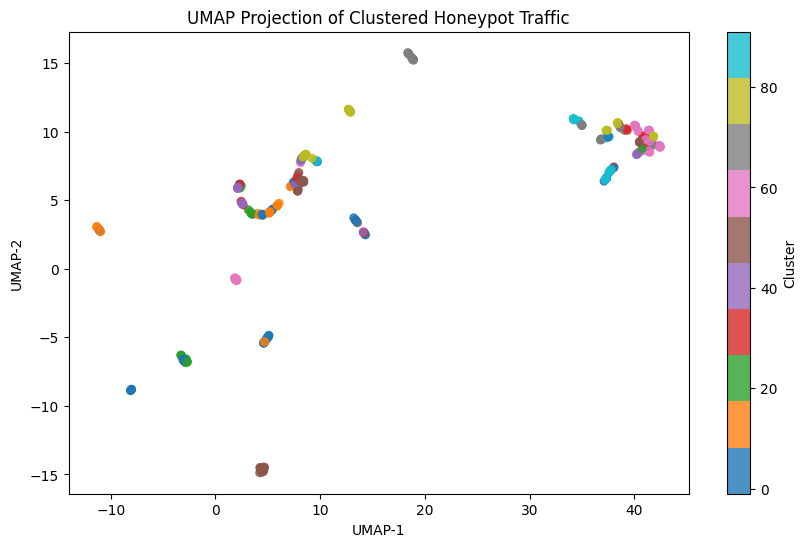

In [53]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    train_data["umap_x"],
    train_data["umap_y"],
    c=train_data["cluster"],
    cmap="tab10",
    s=30,
    alpha=0.8
)

plt.title("UMAP Projection of Clustered Honeypot Traffic")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Cluster")
plt.show()



In [54]:
from sklearn.preprocessing import normalize

endpoint_counts = (
    train_data.explode("paths")
    .groupby(["cluster", "paths"])
    .size()
    .unstack(fill_value=0)
)

# Optional: only show top 20 paths
top_paths = endpoint_counts.sum().sort_values(ascending=False).head(20).index
heatmap_data = endpoint_counts[top_paths]


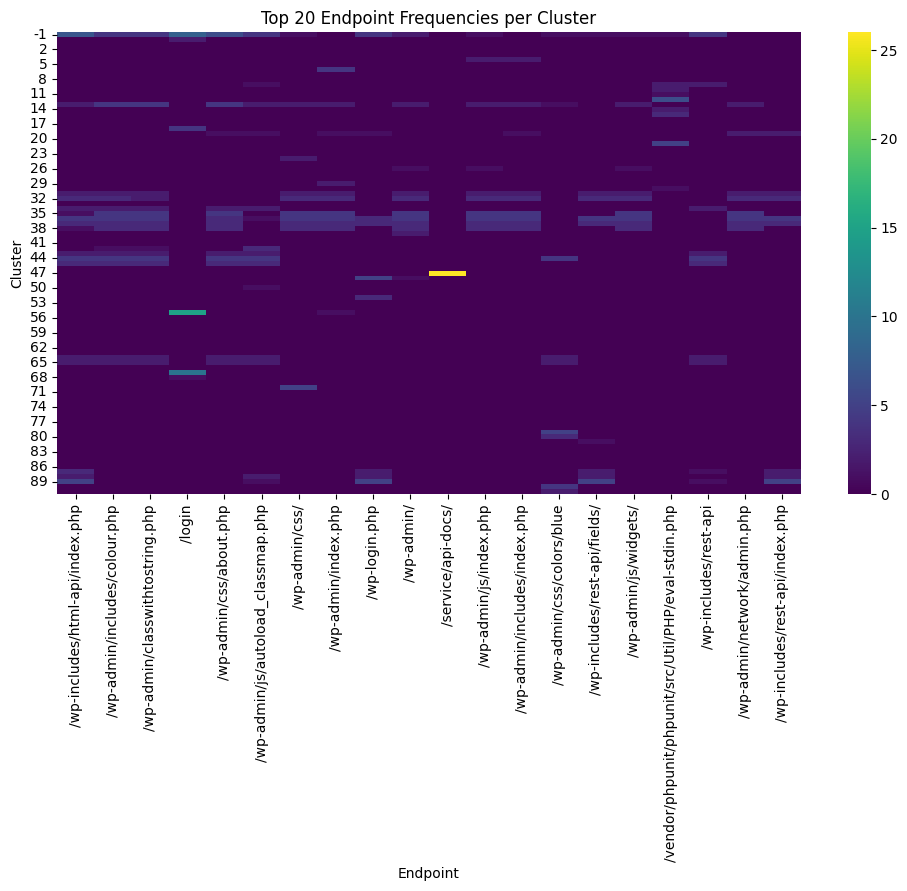

In [55]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="viridis")
plt.title("Top 20 Endpoint Frequencies per Cluster")
plt.xlabel("Endpoint")
plt.ylabel("Cluster")
plt.show()


# Labelling Clusters

In [56]:
SIGNALS = {
    "PHPUnit RCE Scanner": ["phpunit", "eval-stdin.php", "vendor/phpunit", "/lib/phpunit"],
    ".env Secret Harvester": [".env", ".env.local", ".env.dev", ".env.production", ".env.staging", ".env.bak"],
    "WordPress Scanner": ["/wp-admin", "/wp-includes", "wp-content", "xmlrpc.php"],
    "Credential Stuffing / Login Probe": ["/login", "login.html", "formlogin", "/remote/login", "wp-login.php"],
    "API Discovery / Docs": ["swagger", "api-docs", "v0/api-docs", "swagger.json", "graphql"],
    "Enterprise Login Brute Force": ["centreon", "nidp", "mailinspector", "login.action", "hoverfly"],
    "Device Exposure Scanner": ["sonicos", "boaform"],


    "Normal / Legitimate": ["/assets/", ".js", ".css", ".jpg", ".png", ".svg", "favicon.ico", "/movies"]
}


In [57]:
import numpy as np

def session_contains_any(paths_list, keywords):
    blob = " ".join([str(p) for p in paths_list]).lower()
    return any(k.lower() in blob for k in keywords)

def label_cluster_by_percent(grp, min_conf=0.25, tie_gap=0.05):
    n = len(grp)
    scores = {}

    for label, keywords in SIGNALS.items():
        hits = grp["paths"].apply(lambda p: session_contains_any(p, keywords)).sum()
        scores[label] = hits / n

    # pick top-2
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    best_label, best_score = ranked[0]
    second_label, second_score = ranked[1]

    # Unknown if weak evidence
    if best_score < min_conf:
        return "Unknown / Other", best_score, scores

    # Unknown (or Mixed) if ambiguous
    if (best_score - second_score) < tie_gap and best_score < 0.6:
        return f"Mixed: {best_label} + {second_label}", best_score, scores

    return best_label, best_score, scores


In [58]:
cluster_labels = {}
cluster_conf = {}

for cid, grp in train_data.groupby("cluster"):
    label, conf, _scores = label_cluster_by_percent(grp)
    cluster_labels[cid] = label
    cluster_conf[cid] = conf

train_data["cluster_label"] = train_data["cluster"].map(cluster_labels)
train_data["label_conf"] = train_data["cluster"].map(cluster_conf)

train_data[["cluster","cluster_label","label_conf"]].drop_duplicates().sort_values("cluster")


,cluster,cluster_label,label_conf
108,-1,WordPress Scanner,0.617647
550,0,Credential Stuffing / Login Probe,1.000000
518,1,Mixed: .env Secret Harvester + Credential Stuf...,0.500000
532,2,Unknown / Other,0.000000
89,3,Device Exposure Scanner,1.000000
...,...,...,...
195,87,WordPress Scanner,1.000000
144,88,WordPress Scanner,1.000000
116,89,WordPress Scanner,1.000000
119,90,WordPress Scanner,1.000000
